# Multilingual CLIP

## Install Requirements and Download OpenAI CLIP Model
This section might take some minutes.

In [ ]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)
if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex
!pip install ftfy==5.8
!pip install transformers
!pip install open_clip_torch

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import open_clip
import transformers
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

import warnings
warnings.filterwarnings("ignore")

!pip install git+https://github.com/openai/CLIP.git
import clip

CUDA version: 11.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
tcmalloc: large alloc 1156751360 bytes == 0x3bbe000 @  0x7f852dee31e7 0x4b2590 0x5ad01c 0x5dcfef 0x58f92b 0x590c33 0x5e48ac 0x4d20fa 0x51041f 0x58fd37 0x50ca37 0x58fd37 0x50ca37 0x5b575e 0x4bad0a 0x4d3249 0x591e56 0x50e18c 0x5b4ee6 0x4bad0a 0x4d3249 0x591e56 0x50e18c 0x5b4ee6 0x4bad0a 0x4d3249 0x591e56 0x50e18c 0x5b575e 0x4bad0a 0x4d3249
tcmalloc: large alloc 1445945344 bytes == 0x48ae8000 @  0x7f852dee4615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x50ca37 0x5b4ee6 0x58ff2e 0x50ca37 0x5b4ee6 0x58ff2e 0x50ca37 0x5b4ee6 0x58ff2e 0x50ca37 0x5b4ee6 0x58ff2e 0x50ca37 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50ca37 0x5b575e 0x58ff2e 0x50ca37
  Using cached https://download.pytorch.org/whl/cu110/torch-1.7.1%2Bcu110-cp37-cp37m-linux_x86_64.whl (1156.8 MB)
  Using cached htt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached torch-1.12.1-cp37-cp37m-manylinux1_x86_64.whl (776.3 MB)
  Using cached torchvision-0.13.1-cp37-cp37m-manylinux1_x86_64.whl (19.1 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.7.1+cu110
    Uninstalling torch-1.7.1+cu110:
      Successfully uninstalled torch-1.7.1+cu110
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.8.2+cu110
    Uninstalling torchvision-0.8.2+cu110:
      Successfully uninstalled torchvision-0.8.2+cu110


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-5saca67h
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-5saca67h



### Load The Multilingual Text Encoder

In [ ]:
class MCLIPConfig(transformers.PretrainedConfig):
    model_type = "M-CLIP"

    def __init__(self, modelBase='xlm-roberta-large', transformerDimSize=1024, imageDimSize=768, **kwargs):
        self.transformerDimensions = transformerDimSize
        self.numDims = imageDimSize
        self.modelBase = modelBase
        super().__init__(**kwargs)


class MultilingualCLIP(transformers.PreTrainedModel):
    config_class = MCLIPConfig

    def __init__(self, config, *args, **kwargs):
        super().__init__(config, *args, **kwargs)
        self.transformer = transformers.AutoModel.from_pretrained(config.modelBase, cache_dir=kwargs.get("cache_dir"))
        self.LinearTransformation = torch.nn.Linear(in_features=config.transformerDimensions,
                                                    out_features=config.numDims)

    def forward(self, txt, tokenizer, device):
        txt_tok = tokenizer(txt, padding=True, return_tensors='pt').to(device)
        embs = self.transformer(**txt_tok)[0]
        att = txt_tok['attention_mask']
        embs = (embs * att.unsqueeze(2)).sum(dim=1) / att.sum(dim=1)[:, None]
        return self.LinearTransformation(embs)

    @classmethod
    def _load_state_dict_into_model(cls, model, state_dict, pretrained_model_name_or_path, _fast_init=True):
        model.load_state_dict(state_dict)
        return model, [], [], []

In [ ]:
texts = [
    'Three blind horses listening to Mozart.',
    'Älgen är skogens konung!',
    'Wie leben Eisbären in der Antarktis?',
    'Вы знали, что все белые медведи левши?'
]
model_name = 'M-CLIP/XLM-Roberta-Large-Vit-B-16Plus'

# Load Model & Tokenizer
text_model = MultilingualCLIP.from_pretrained(model_name)
text_model = text_model.to(device)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

embeddings = text_model.forward(texts, tokenizer, device)
print(embeddings.shape)

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([4, 640])


### Load The Matching CLIP Model

In [ ]:
clip_model, _, compose = open_clip.create_model_and_transforms('ViT-B-16-plus-240', pretrained="laion400m_e32")
clip_model = clip_model.to(device)

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")

Model parameters: 208,377,345


### Read in the Images

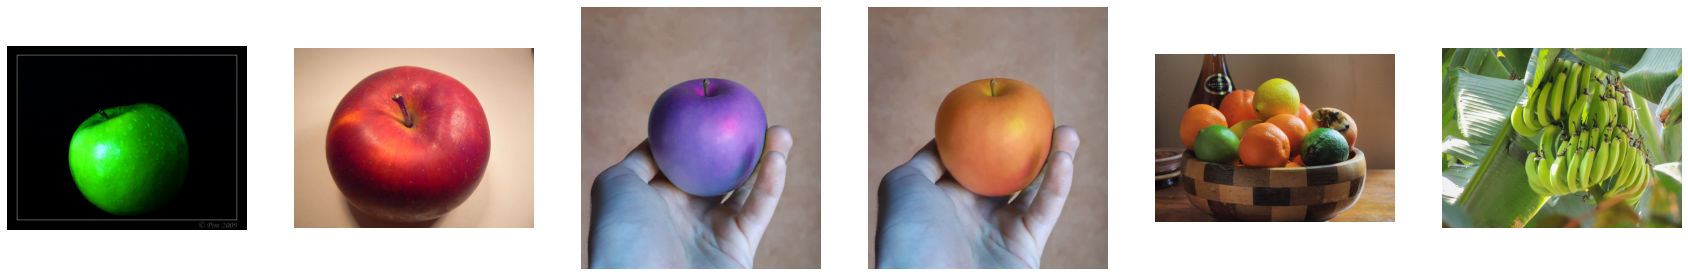

In [ ]:
main_path = '/content/Multilingual-CLIP/Images/'
demo_images = {
    'Green Apple': 'green apple.jpg',
    'Red Apple': 'red apple.jpg',
    'Purple Apple': 'purple apple.png',
    'Orange Apple': 'Orange Apple.png',
    'Fruit Bowl': 'fruit bowl.jpg',
    'Bananas on Tree': 'bananas.jpg',
}
images = {name: Image.open(main_path + p) for name, p in demo_images.items()}

fig = plt.figure()
fig.set_size_inches(30,5)
for i, img in enumerate(images.values()):
  a=fig.add_subplot(1,len(images), i+1)
  plt.imshow(img, )
  plt.axis('off')

### Create Captions

In [ ]:
russan_captions = [
    'Зеленое яблоко', 'Красное яблоко', 'Фиолетовое яблоко', 'Апельсиновое яблоко', 'Миска с фруктами', 'Гроздь бананов свисает с дерева'  
]

french_captions = [
  'Une pomme verte', 'Une pomme rouge', 'Une pomme violette', 'Une pomme orange', 'Un bol rempli de fruits', 'Un tas de bananes pendu à un arbre'           
]

german_captions = [
  'Ein grüner Apfel', 'Ein roter Apfel', 'Ein lila Apfel', 'Ein orangefarbener Apfel', 'Eine Schüssel voller Früchte', 'Ein Bündel Bananen hängt an einem Baum'           
]

spanish_captions = [
    'Una manzana verde', 'Una manzana roja', 'Una manzana de color lila', 'Una manzana de color naranja', 'Un frutero lleno de fruta', 'Un racimo de bananas colgados de un banano',
]

greek_captions = [
    'Ένα πράσινο μήλο', 'Ένα κόκκινο μήλο', 'Ένα μοβ μήλο', 'Ένα πορτοκαλί μήλο', 'Ένα μπολ γεμάτο με φρούτα', 'Ένα τσαμπί μπανάνες κρεμάμενες από ένα δέντρο',
]

swedish_captions = [
  'Ett grönt äpple', 'Ett rött äpple', 'Ett lila äpple', 'Ett oranget äpple', 'En skål fylld med frukt', 'En klase bananer som hänger från ett träd'           
]

all_captions = {'Russian': russan_captions, 'French': french_captions, 'German': german_captions,
                'Spanish': spanish_captions, 'Greek': greek_captions, 'Swedish': swedish_captions
                }

### Prepare Images for CLIP

In [ ]:
img_input = torch.stack([compose(img).to(device) for img in images.values()])

### Generate Text & Vision Embeddings

In [ ]:
with torch.no_grad():
    image_embs = clip_model.encode_image(img_input).float().to(device)

    language_embs = {}
    for lang, captions in all_captions.items():
      language_embs[lang] = text_model.forward(captions, tokenizer, device).to(device)

print("CLIP-Vision: {}".format(image_embs.shape))
for lang, embs in language_embs.items():
  print("{}: {}".format(lang, embs.shape))

CLIP-Vision: torch.Size([6, 640])
Russian: torch.Size([6, 640])
French: torch.Size([6, 640])
German: torch.Size([6, 640])
Spanish: torch.Size([6, 640])
Greek: torch.Size([6, 640])
Swedish: torch.Size([6, 640])


### Compare Predictions

Compare the Cosine-Similarities between the image embeddings and the different language embeddings.

In [ ]:
def compare_embeddings(logit_scale, img_embs, txt_embs):
  # normalized features
  image_features = img_embs / img_embs.norm(dim=-1, keepdim=True)
  text_features = txt_embs / txt_embs.norm(dim=-1, keepdim=True)

  # cosine similarity as logits
  logits_per_image = logit_scale * image_features @ text_features.t()
  logits_per_text = logit_scale * text_features @ image_features.t()

  # shape = [global_batch_size, global_batch_size]
  return logits_per_image, logits_per_text

# CLIP Temperature scaler
logit_scale = clip_model.logit_scale.exp().float().to(device)

language_logits = {}
for lang, embs in language_embs.items():
  language_logits[lang] = compare_embeddings(logit_scale, image_embs, embs)

### Visualize Results

Here we will not visualize the results, so that every column is the Softmax distribution over all the texts for the respective image.

Language: Russian


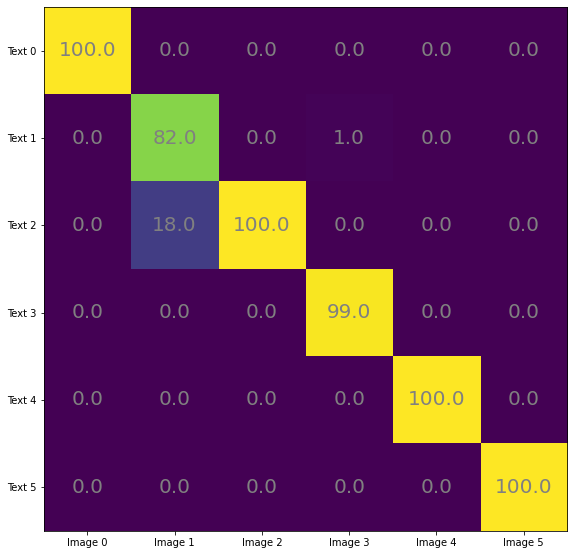

Language: French


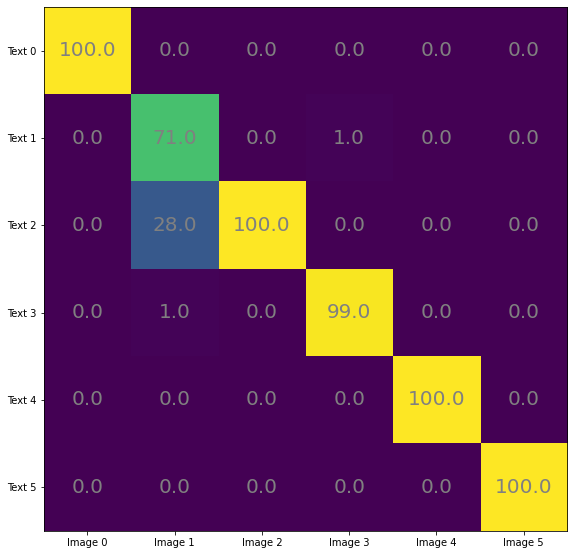

Language: German


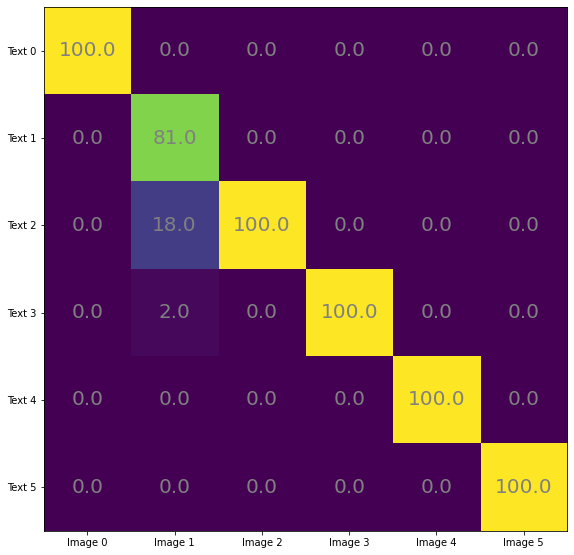

Language: Spanish


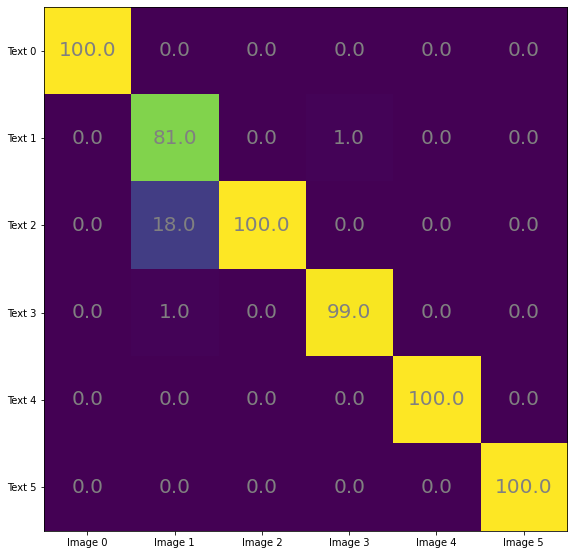

Language: Greek


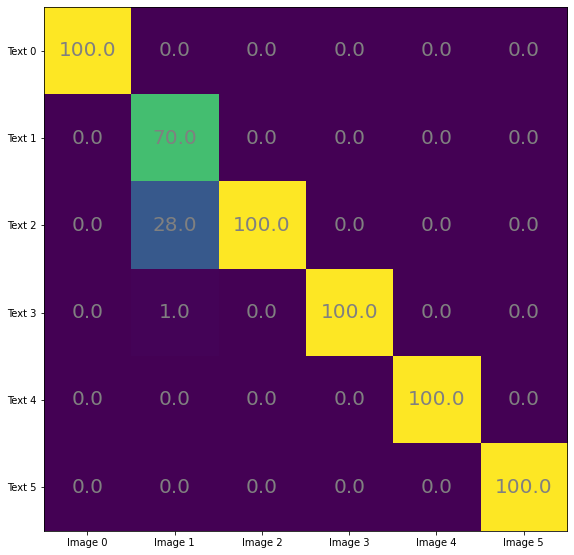

Language: Swedish


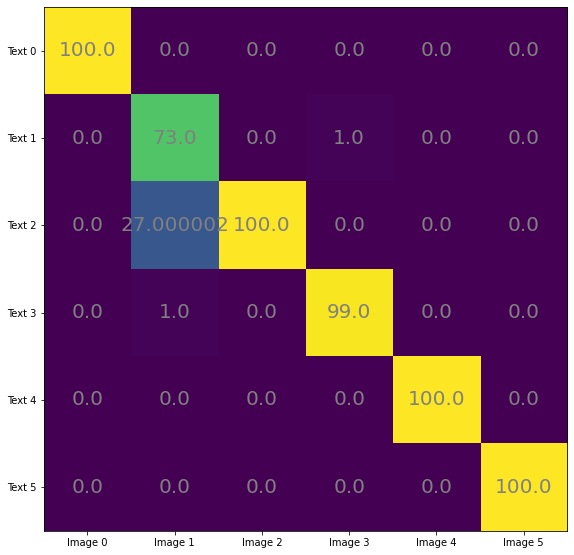

In [ ]:
def plot_heatmap(result_matrix):
  height, width = result_matrix.shape
  fig, ax = plt.subplots()
  fig.set_size_inches(8,8)
  im = ax.imshow(result_matrix)

  # Create X & Y Labels
  ax.set_xticks(np.arange(width))
  ax.set_yticks(np.arange(height))
  ax.set_xticklabels(["Image {}".format(i) for i in range(width)])
  ax.set_yticklabels(["Text {}".format(i) for i in range(height)])

  for i in range(height):
    for j in range(width):
        text = ax.text(j, i, result_matrix[i, j],
                       ha="center", va="center", color='grey', size=20)

  fig.tight_layout()
  plt.show()

for lang, (img_logits, txt_logits) in language_logits.items():
  # Convert Logits into Softmax predictions
  probs = img_logits.softmax(dim=-1).cpu().detach().numpy()

  # Transpose so that each column is the softmax for each picture over the texts
  probs = np.around(probs, decimals=2).T * 100

  print("Language: {}".format(lang))
  plot_heatmap(probs)

## Conclusion
Although the diagonal is not completely maxed out, all languages managed to correctly classify all images. Interestingly, all languages had an easier time classifying the purple apple which was photoshopped than the red apple.